# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups

    # new splatter requires dropout.type
    if ('dropout.type' %in% slotNames(newSplatParams())) {
        if (dropout)
            dropout.type <- 'experiment'
        else
            dropout.type <- 'none'
        
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.type=dropout.type, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)

    } else {
        sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                             dropout.present=!dropout, method=method,
                             seed=42, dropout.shape=-1, dropout.mid=dropout)        
    }

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

R[write to console]: Loading required package: SingleCellExperiment

R[write to console]: Loading required package: SummarizedExperiment

R[write to console]: Loading required package: GenomicRanges

R[write to console]: Loading required package: stats4

R[write to console]: Loading required package: BiocGenerics

R[write to console]: Loading required package: parallel

R[write to console]: 
Attaching package: ‘BiocGenerics’


R[write to console]: The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


R[write to console]: The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


R[write to console]: The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, 

## Generate AnnData objects and analyze in Scanpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from dca.api import dca

Using TensorFlow backend.
/usr/local/lib/python3.7/site-packages/kopt/config.py:60: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


In [4]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)
adata

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'

In [5]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2'

In [6]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [7]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

2019-09-03 13:48:08,430 [WARNING] From /Users/user/Code/dca/dca/api.py:149: The name tf.set_random_seed is deprecated. Please use tf.compat.v1.set_random_seed instead.



dca: Successfully preprocessed 198 genes and 2000 cells.



2019-09-03 13:48:08,469 [WARNING] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



2019-09-03 13:48:08,474 [WARNING] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



2019-09-03 13:48:08,557 [WARNING] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:148: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.



2019-09-03 13:48:08,773 [WARNING] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


2019-09-03 13:48:08,889 [WARNING] From /Users/user/Code/dca/dca/loss.py:10: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


dca: Calculating reconstructions...
CPU times: user 23.6 s, sys: 357 ms, total: 24 s
Wall time: 24 s


In [8]:
adata_ae

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'n_counts'
    uns: 'dca_loss', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical
... storing 'Group' as categorical


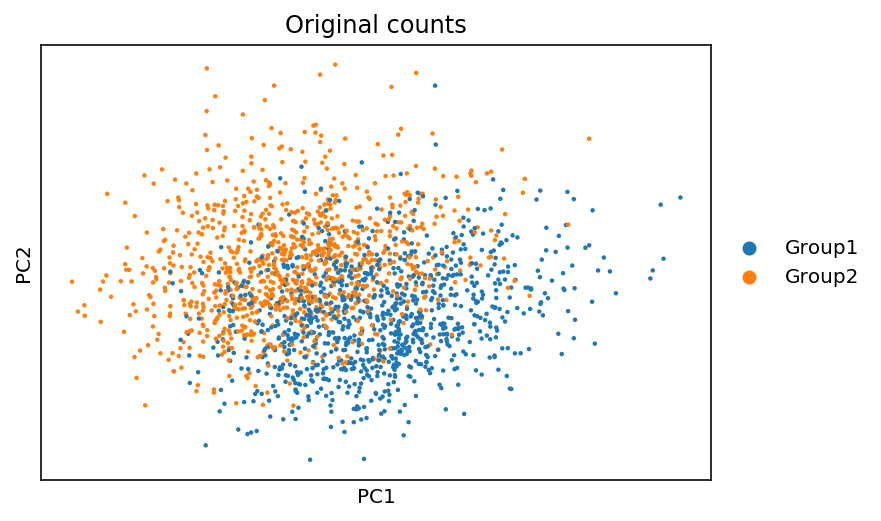

... storing 'Batch' as categorical
... storing 'Group' as categorical


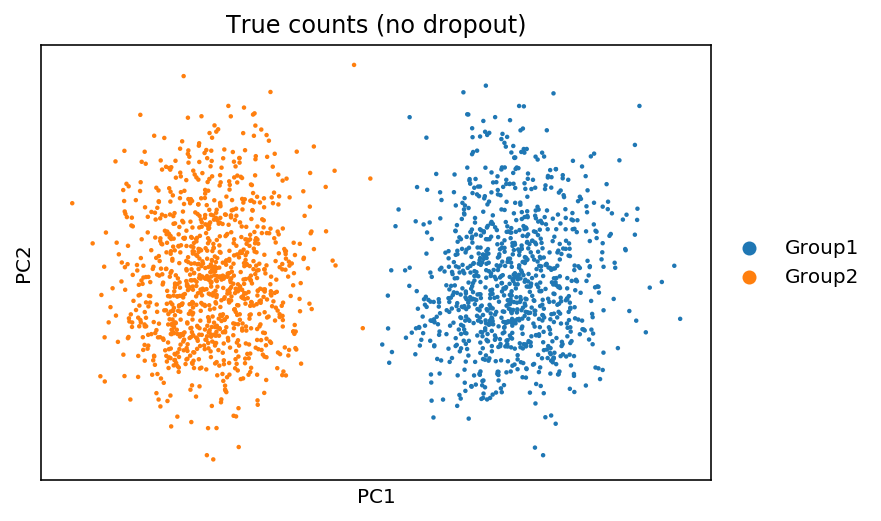

... storing 'Batch' as categorical
... storing 'Group' as categorical


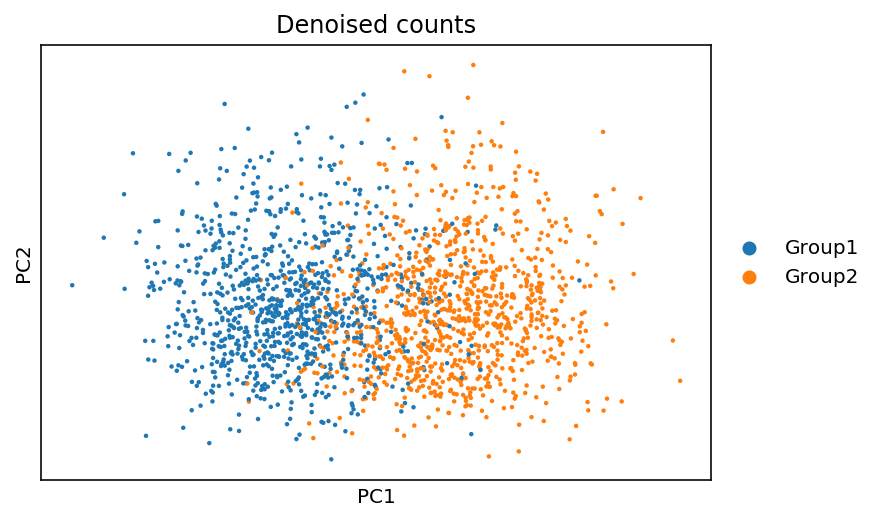

In [9]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

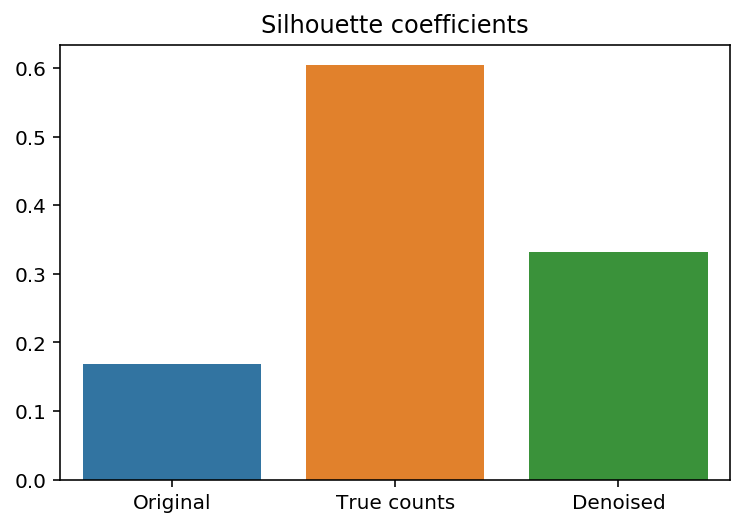

In [10]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_pca'][:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_pca'][:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm['X_pca'][:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

In [11]:
adata._sanitize()
adata_ae._sanitize()

In [12]:
adata.obs.Group

Cell
Cell1       Group1
Cell2       Group1
Cell3       Group2
Cell4       Group1
Cell5       Group1
             ...  
Cell1996    Group2
Cell1997    Group2
Cell1998    Group2
Cell1999    Group2
Cell2000    Group1
Name: Group, Length: 2000, dtype: category
Categories (2, object): [Group1, Group2]

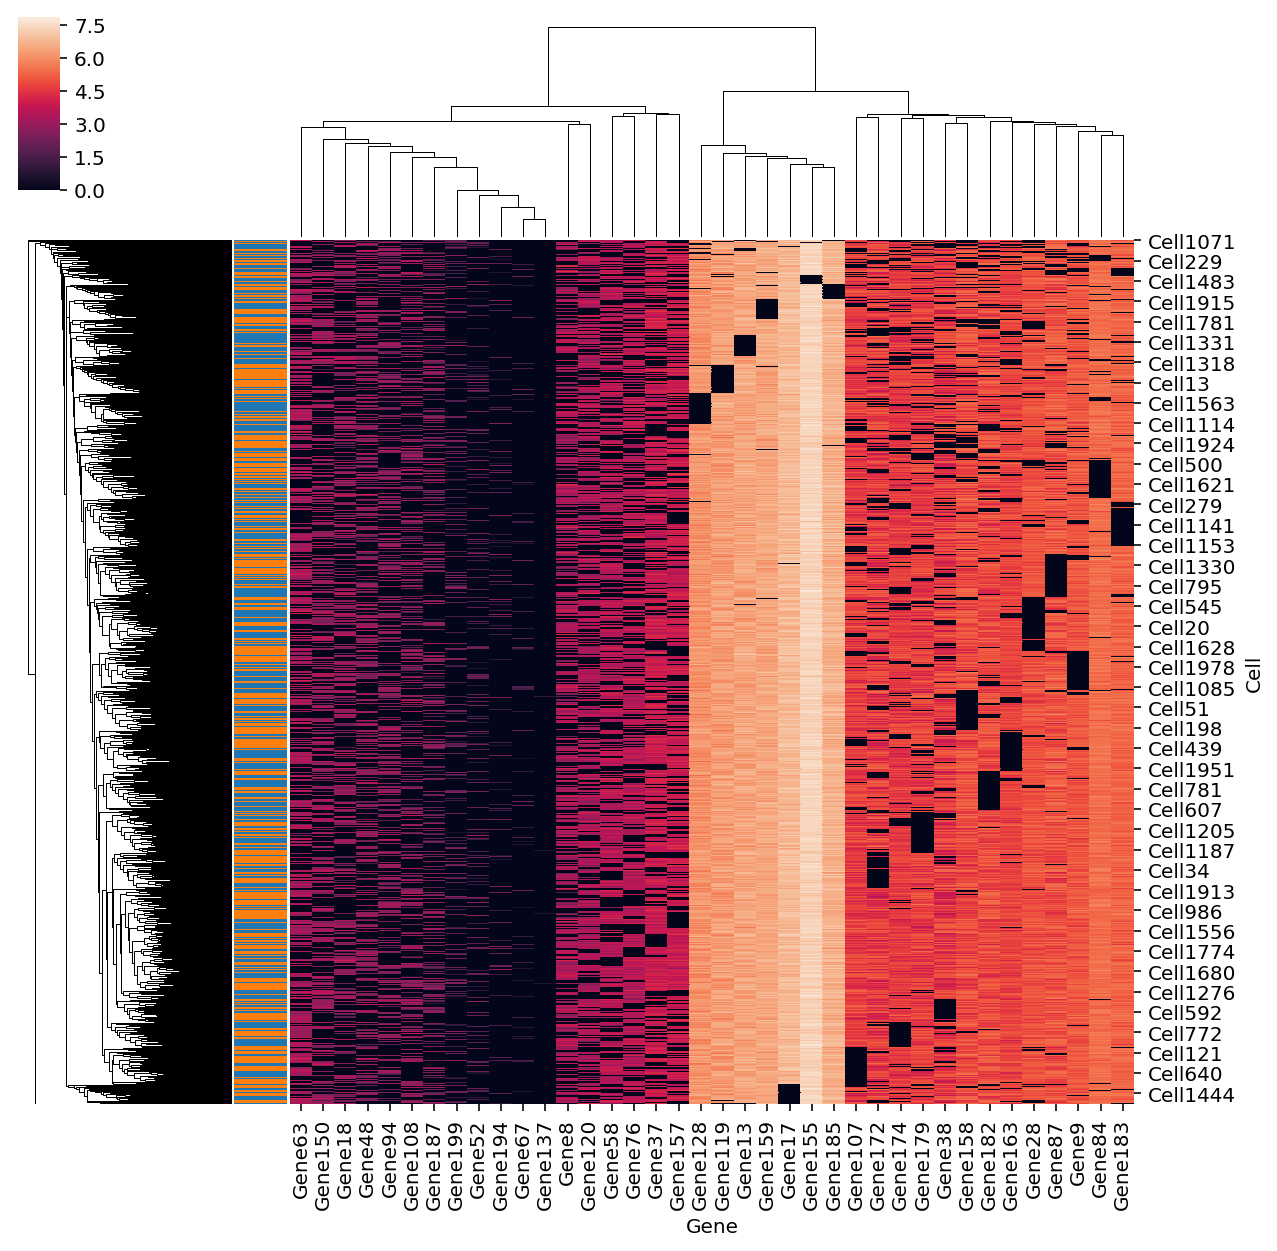

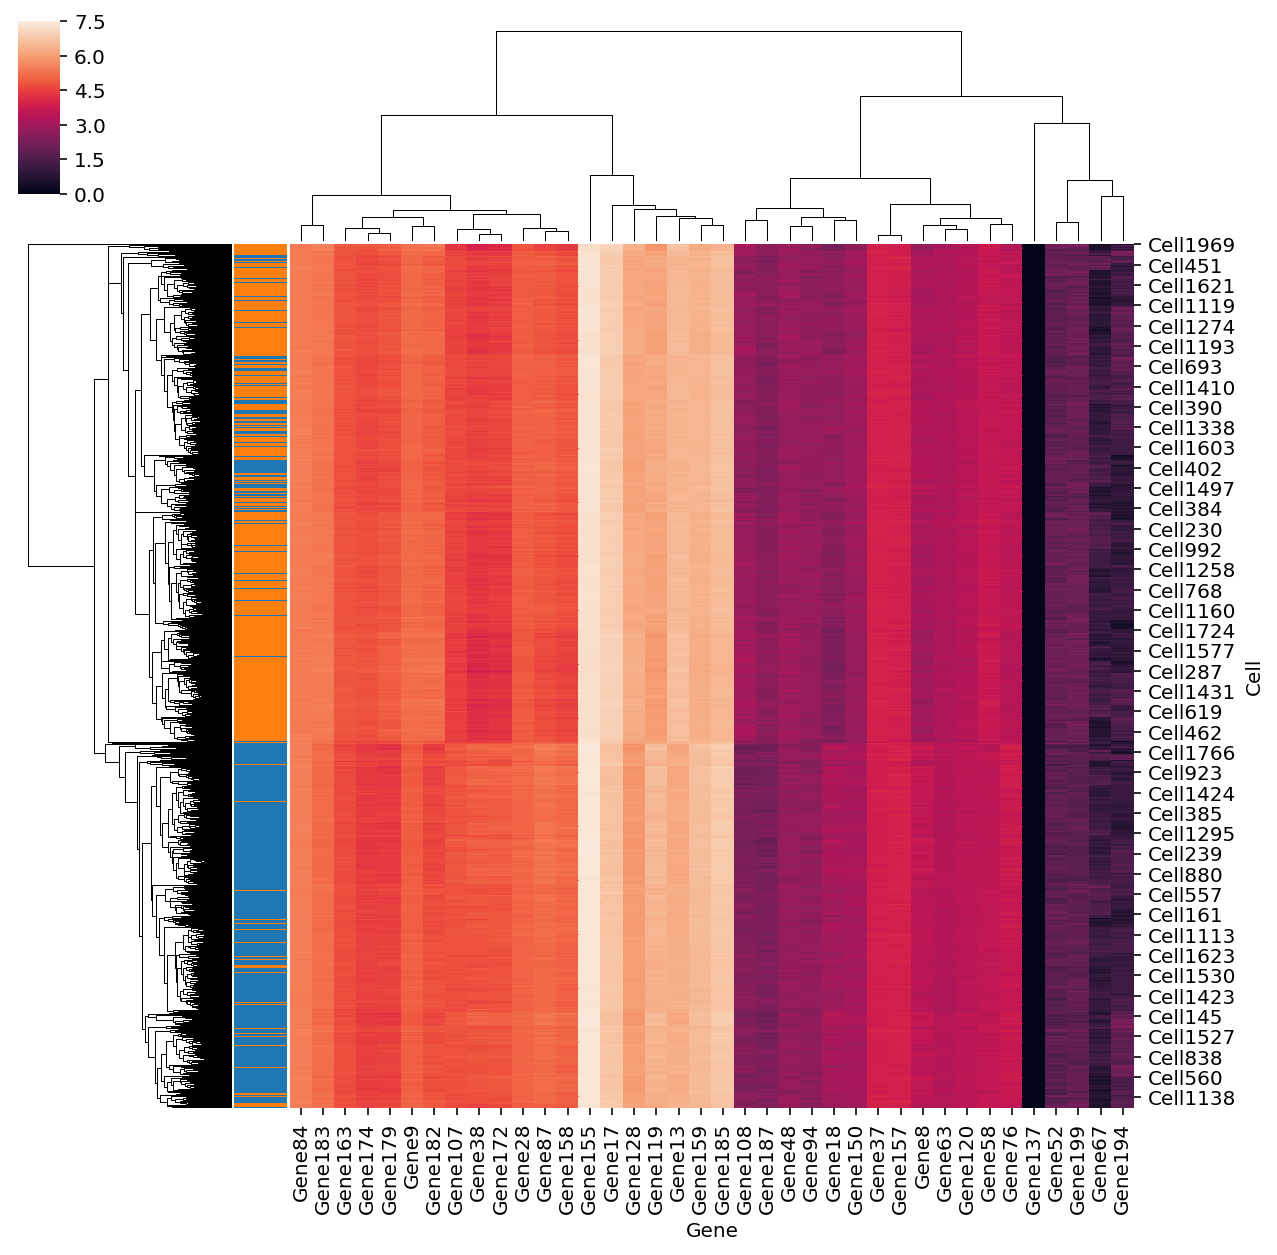

In [13]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)

## Simulate six groups

In [14]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

2019-09-03 13:48:37,443 [WARNING] R[write to console]: Getting parameters...

2019-09-03 13:48:37,461 [WARNING] R[write to console]: Creating simulation object...

2019-09-03 13:48:37,531 [WARNING] R[write to console]: Simulating library sizes...

2019-09-03 13:48:37,535 [WARNING] R[write to console]: Simulating gene means...

2019-09-03 13:48:37,579 [WARNING] R[write to console]: Simulating group DE...

2019-09-03 13:48:37,604 [WARNING] R[write to console]: Simulating cell means...

2019-09-03 13:48:37,667 [WARNING] R[write to console]: Simulating BCV...

2019-09-03 13:48:37,761 [WARNING] R[write to console]: Simulating counts...

2019-09-03 13:48:37,822 [WARNING] R[write to console]: Simulating dropout (if needed)...

2019-09-03 13:48:37,971 [WARNING] R[write to console]: Done!



In [15]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
sc.pp.filter_genes(adata, min_counts=1)

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true = adata_true[:, adata.var_names].copy()
adata_true

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6'

In [16]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [17]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

sc.pp.filter_genes(adata_ae, min_counts=1)
dca(adata_ae, threads=1)

sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

dca: Successfully preprocessed 198 genes and 2000 cells.
dca: Calculating reconstructions...
         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 43 s, sys: 457 ms, total: 43.5 s
Wall time: 43.5 s


AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'dca_split', 'n_counts', 'size_factors'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'dca_loss'
    obsm: 'X_pca', 'X_tsne'

... storing 'Batch' as categorical
... storing 'Group' as categorical


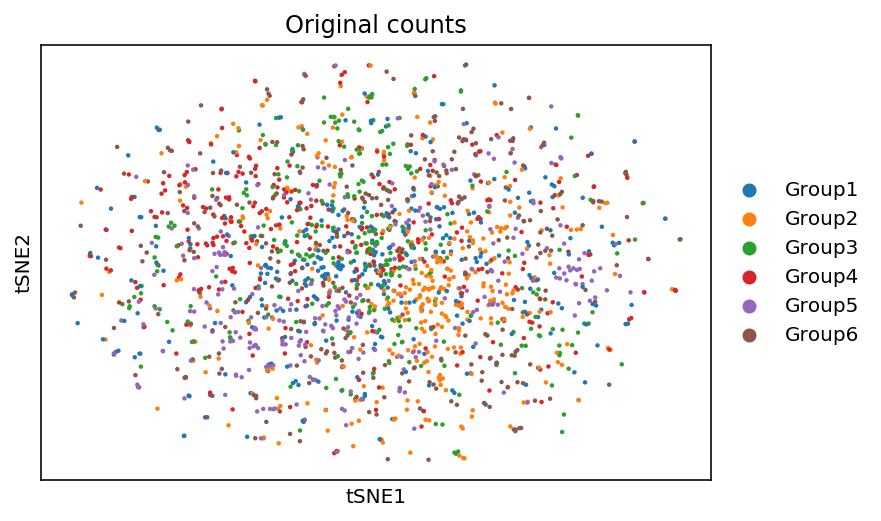

... storing 'Batch' as categorical
... storing 'Group' as categorical


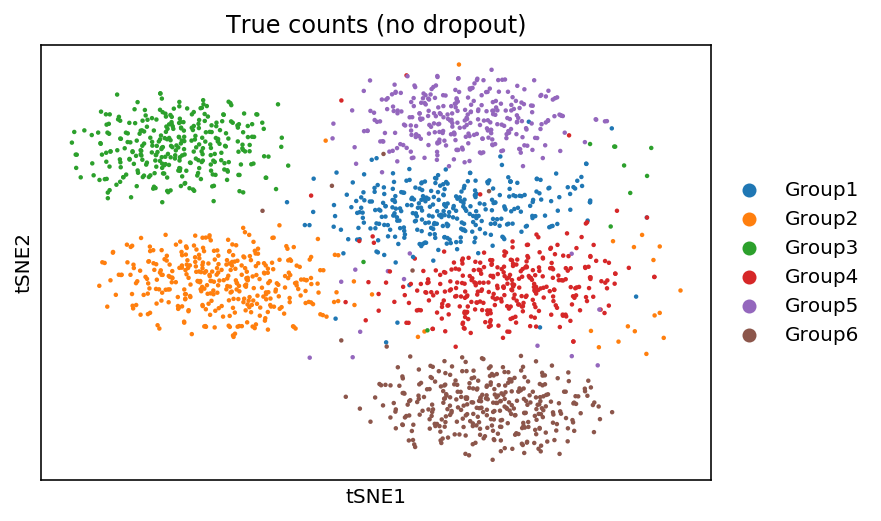

... storing 'Batch' as categorical
... storing 'Group' as categorical


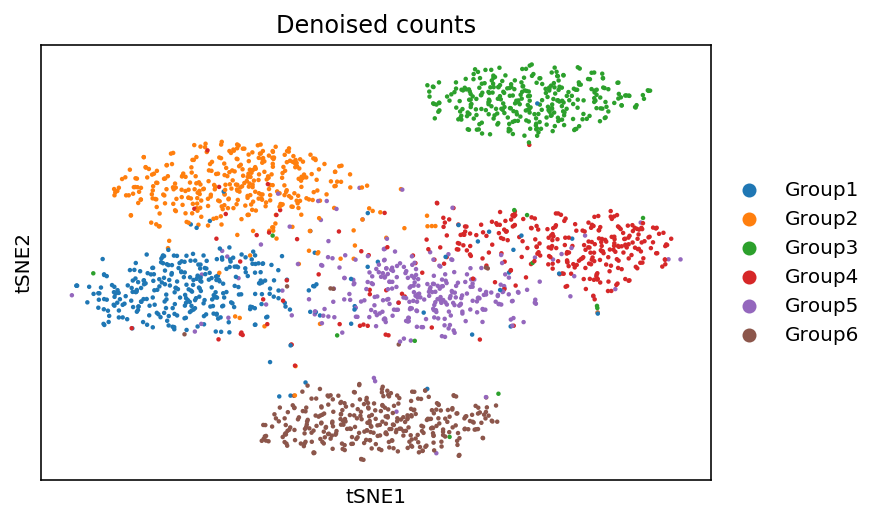

In [18]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

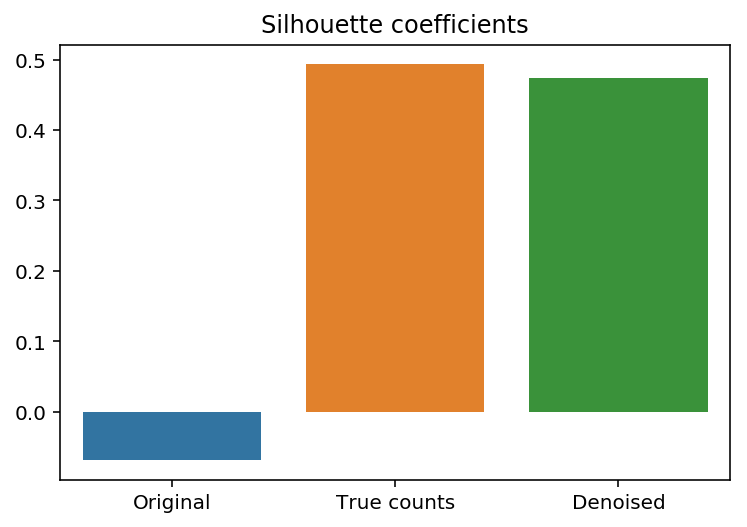

In [19]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm['X_tsne'], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm['X_tsne'], adata_true.obs.Group)
sil_ae   = silhouette_score(adata_ae.obsm['X_tsne'], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [20]:
adata

AnnData object with n_obs × n_vars = 2000 × 198 
    obs: 'Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts'
    var: 'Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6', 'n_counts'
    uns: 'pca', 'Group_colors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

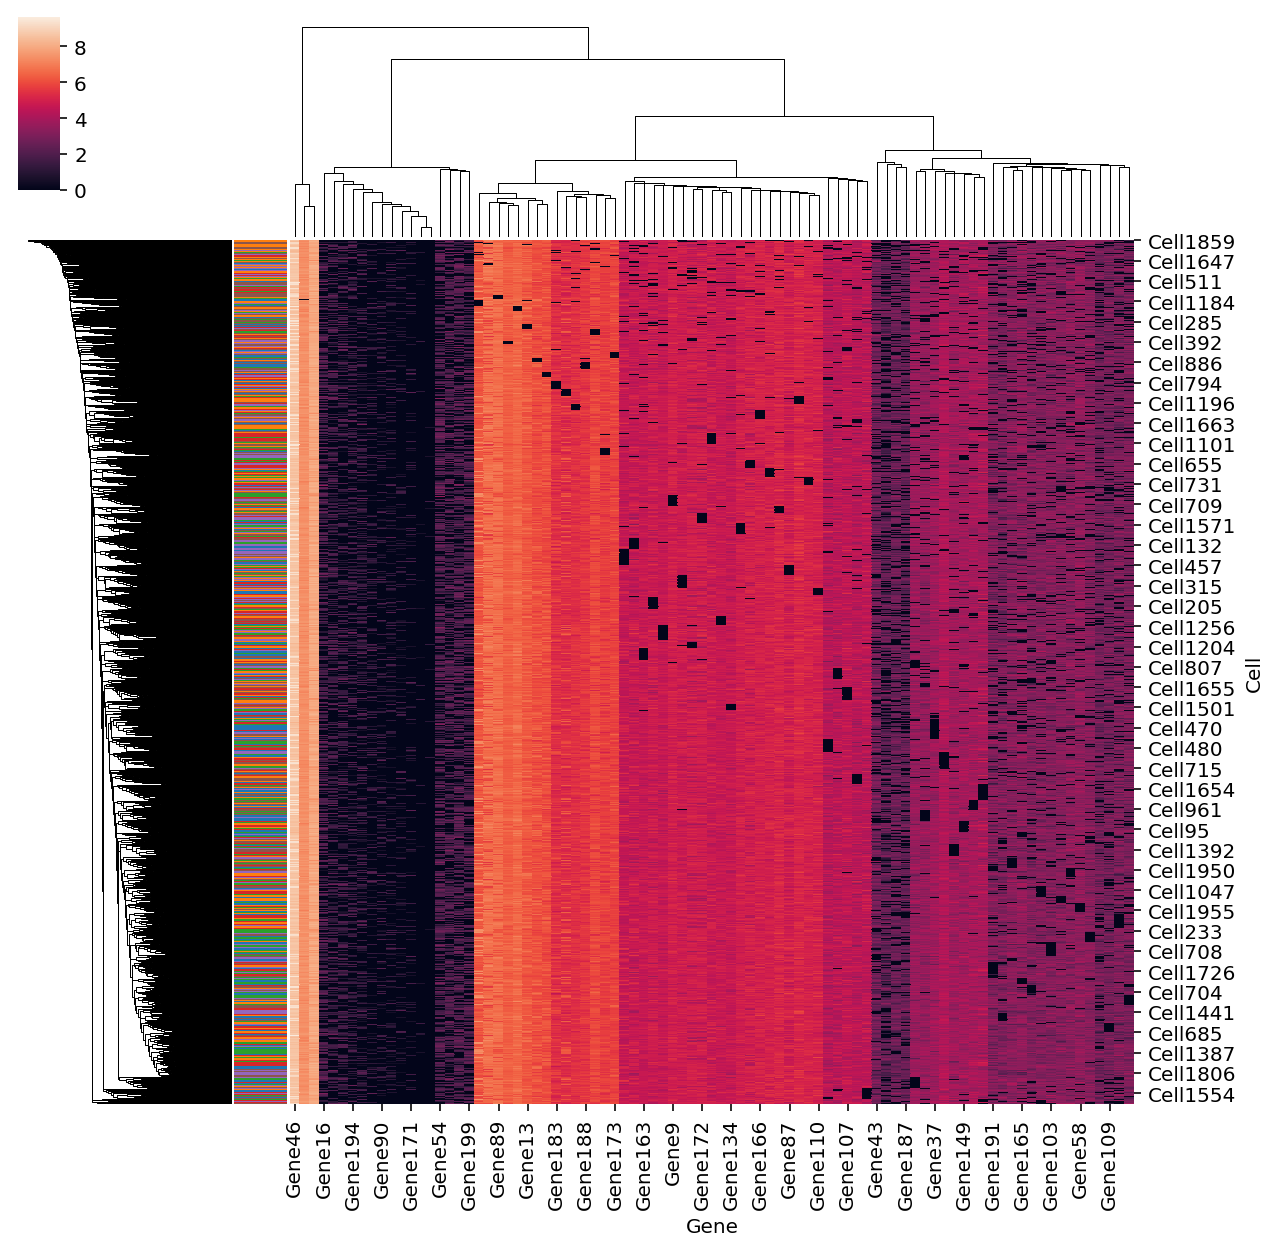

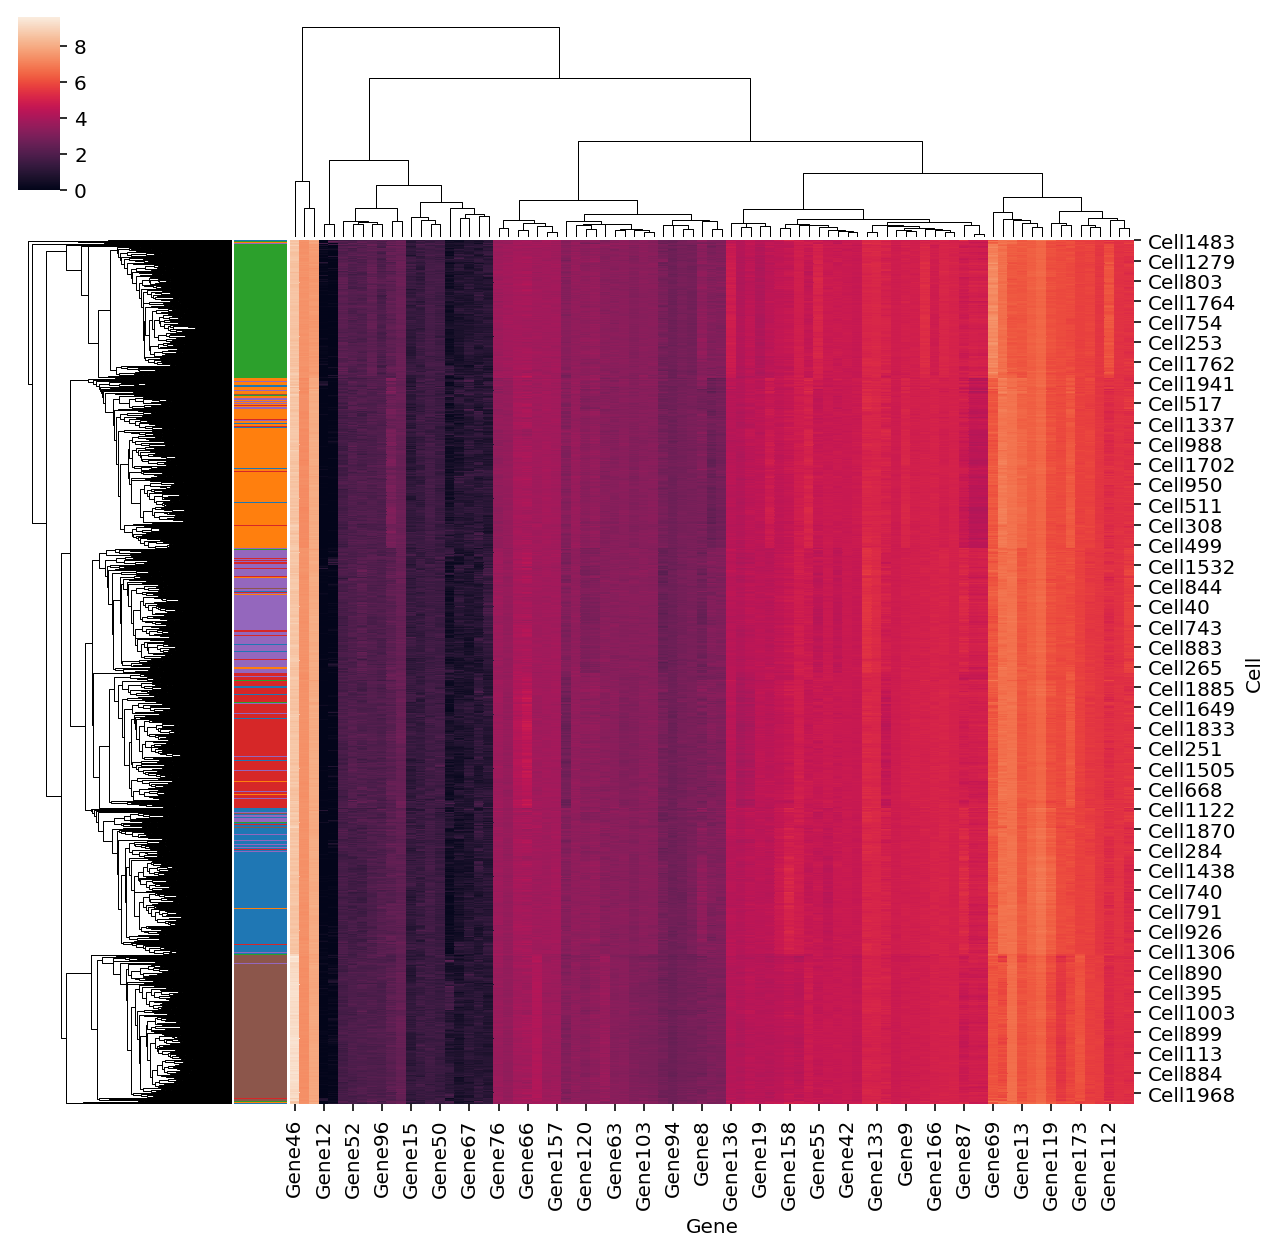

In [21]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group', use_raw=False)
sc.pl.clustermap(adata_ae[:, de_genes], 'Group', use_raw=False)